<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/5.1.1-LSTMB-500k-nodropout-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Prototype (Balanced Weights/No Dropout) - 500k samples

LSTM is generally doing pretty good in our deep learning models. In our last notebook, we ran LSTM network with default weights - ie, penalty for mis-classification is the same across all classes.

In this notebook, we will use 'balanced' weights calculated by sklearn's compute_class_weight with 500 k training examples to see how this affects our performance. We will also remove dropout in our LSTM units and compare performance to LSTMB with dropout.

Our basline scores 

* 200k without dropout: 0.3468204539968095
* 500k with dropout: 0.3940089448147528


# Conclusion

Our score is 0.36278683733988865

With 500k samples, we do see a slight improvement over using only 200k samples.

However, compared to model where we used dropout in our LSTM unit, we are performing worse by around 0.03


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


'/device:GPU:0'

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru



logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


DEBUG = False


MODEL_NAME = "LSTMB_nodropout"
LSTM_DIM = 64 # total LSTM units
ARCHITECTURE = f"1x{LSTM_DIM}"
DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units No Dropout - Balanced Weights"
FEATURE_SET_NAME = "random_embedding"
PATIENCE = 8

if DEBUG:
  DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
  MODEL_NAME = f'test-{MODEL_NAME}'
else:
  DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-500k-preprocessed.csv"


# first layer filter
FILTER1 = 32
# Network Settings
KERNEL_SIZE=3



# length of our embedding - 300 is standard
EMBED_SIZE = 300
EPOCHS  = 50
BATCH_SIZE = 128

# From EDA, we know that 90% of review bodies have 100 words or less, 
# we will use this as our sequence length
MAX_SEQUENCE_LENGTH = 100



In [0]:
df = pd.read_csv(DATA_FILE)

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

# Preprocessing

In [4]:


# pre-process our lables
# one hot encode our star ratings since Keras/TF requires this for the labels
y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1, test_size=0.1)


# Pre-process our features (review body)
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(reviews_train)
# tokenize both our training and test data
train_sequences = t.texts_to_sequences(reviews_train)
test_sequences = t.texts_to_sequences(reviews_test)

print("Vocabulary size={}".format(len(t.word_counts)))
print("Number of Documents={}".format(t.document_count))


# pad our reviews to the max sequence length
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Train review vectors shape:', X_train.shape, ' Test review vectors shape:', X_test.shape)


Vocabulary size=81867
Number of Documents=448051
Train review vectors shape: (448051, 100)  Test review vectors shape: (49784, 100)


**Build LSTM Model Architecture**

In [0]:
vocab_size = len(t.word_counts)+1

# building our network
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM))
model.add(Dense(5, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["categorical_accuracy"])


In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          24560400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 24,654,165
Trainable params: 24,654,165
Non-trainable params: 0
_________________________________________________________________
None


In [7]:

# reduce learning rate if we sense a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.4,
                              patience=PATIENCE, 
                              min_lr=0.00001,
                             mode='auto')


early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           verbose=1, 
                           restore_best_weights=True)

weights = compute_class_weight('balanced', np.arange(1, 6), rating)
print(f'class weights: {weights}')


mw = ku.ModelWrapper(model, 
                     MODEL_NAME, 
                     ARCHITECTURE,
                     FEATURE_SET_NAME,
                     LABEL_COLUMN, 
                     DATA_FILE, 
                     embed_size=EMBED_SIZE,
                     tokenizer=t,
                     description=DESCRIPTION)

# create a model checkpoint so we save the best weights for our model
# TODO: should refactor this into ModelWrapper - this is not the most eligent way of setting the filename
model_checkpoint = ModelCheckpoint(
    filepath=f'{DRIVE_DIR}/models/{MODEL_NAME}-{ARCHITECTURE}-{FEATURE_SET_NAME}-sampling_None-{X_test.shape[0] + X_train.shape[0]}-{X_test.shape[1]}-{LABEL_COLUMN}.weights', 
                     monitor='val_loss', # use the same metric as our early stopping
                     save_best_only=True, 
                     save_weights_only=True, # save weights file only since ModelWrapper already saves the model
                     verbose=1)

network_history = mw.fit(X_train, y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      verbose=1,
                      validation_split=0.2,
                      class_weight=weights,
                      callbacks=[early_stop, model_checkpoint, reduce_lr])

class weights: [1.41902061 3.0309589  2.20828158 1.20167276 0.37308618]
Number of training examples: 448051
Train on 358440 samples, validate on 89611 samples
Epoch 1/50
358400/358440 [============================>.] - ETA: 0s - loss: 0.8315 - categorical_accuracy: 0.6771
Epoch 00001: val_loss improved from inf to 0.77455, saving model to drive/My Drive/Springboard/capstone/models/LSTMB_nodropout-1x64-random_embedding-sampling_None-49884-100-star_rating.weights
358440/358440 [==============================] - 685s 2ms/sample - loss: 0.8315 - categorical_accuracy: 0.6771 - val_loss: 0.7745 - val_categorical_accuracy: 0.6962
Epoch 2/50
358400/358440 [============================>.] - ETA: 0s - loss: 0.7238 - categorical_accuracy: 0.7171
Epoch 00002: val_loss improved from 0.77455 to 0.76065, saving model to drive/My Drive/Springboard/capstone/models/LSTMB_nodropout-1x64-random_embedding-sampling_None-49884-100-star_rating.weights
358440/358440 [==============================] - 685s 2ms/

Number of test: 49784
Running model.evaluate...
49784/49784 [==============================] - 8s 165us/sample - loss: 0.7613 - categorical_accuracy: 0.7005
Running model.predict...
Unencode predictions...
Generating confusion matrix...
Calculating ROC AUC...
(49784, 5)
Getting classification report...
Accuracy: 70.05%


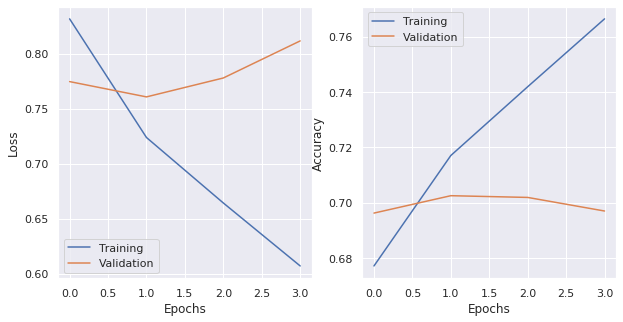


Confusion Matrix
[[ 5359   544   513   127   403]
 [ 1289   612   872   209   277]
 [  573   400  1689   936   982]
 [  187    63   818  2596  4627]
 [  220    41   379  1451 24617]]

Classification Report
              precision    recall  f1-score   support

           1       0.70      0.77      0.74      6946
           2       0.37      0.19      0.25      3259
           3       0.40      0.37      0.38      4580
           4       0.49      0.31      0.38      8291
           5       0.80      0.92      0.85     26708

    accuracy                           0.70     49784
   macro avg       0.55      0.51      0.52     49784
weighted avg       0.67      0.70      0.68     49784



drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:267: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=True)
drive/My Drive/Springboard/capstone/util/plot_util.py:271: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.
  w

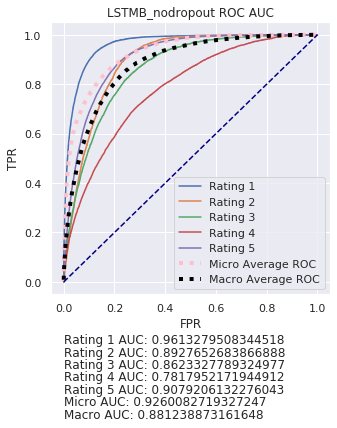

In [8]:

scores = mw.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (mw.scores[1]*100))

pu.plot_network_history(mw.network_history, "categorical_accuracy", "val_categorical_accuracy")
plt.show()

print("\nConfusion Matrix")
print(mw.confusion_matrix)

print("\nClassification Report")
print(mw.classification_report)

fig = plt.figure(figsize=(5,5))
pu.plot_roc_auc(mw.model_name, mw.roc_auc, mw.fpr, mw.tpr)



In [9]:
print(f'Score: {ru.calculate_metric(mw.crd)}')

Score: 0.36278683733988865


**Save off various files**

In [10]:
mw.save(DRIVE_DIR, append_report=True)

description: LSTMB_nodropout-1x64-random_embedding-sampling_none-497835-100-star_rating
Saving model file: drive/My Drive/Springboard/capstone/models/LSTMB_nodropout-1x64-random_embedding-sampling_none-497835-100-star_rating-model.h5
Saving json config file: drive/My Drive/Springboard/capstone/models/LSTMB_nodropout-1x64-random_embedding-sampling_none-497835-100-star_rating-model.json
Saving weights file: drive/My Drive/Springboard/capstone/models/LSTMB_nodropout-1x64-random_embedding-sampling_none-497835-100-star_rating-weights.h5
Saving to report file: drive/My Drive/Springboard/capstone/reports/2020-02-dl_prototype-report.csv
Loading to append to: drive/My Drive/Springboard/capstone/reports/2020-02-dl_prototype-report.csv
{'model_name': 'LSTMB_nodropout', 'architecture': '1x64', 'description': '1 Layer 64 LSTM Units No Dropout - Balanced Weights', 'classification_report': '{"1": {"precision": 0.7025432616675407, "recall": 0.7715231788079471, "f1-score": 0.7354192397420064, "support"

In [11]:
print(datetime.now())

2020-02-05 03:11:07.326023
